Лабороторна робота 2.1 студента К. Д. Долматова
Варіант 3: CIFAR-10

Опис: Класифікація кольорових зображень за 10 категоріями (автомобілі, птахи, кішки, тощо).

Джерело даних: Доступний через TensorFlow/Keras (tf.keras.datasets.cifar10).

Вимоги до моделі:

•	Використання трансферного навчання (наприклад, MobileNet, ResNet)

•	Реалізація техніки fine-tuning

•	Досягнення точності не менше 85% на тестовому наборі


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Параметры
INPUT_SIZE = (96, 96)  # Размер изображения
BATCH_SIZE = 32        # Размер батча
NUM_CLASSES = 10       # Количество классов

# Загрузка CIFAR-10
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10.load_data()

# One-hot кодирование меток
y_train = to_categorical(y_train_raw, NUM_CLASSES)
y_test  = to_categorical(y_test_raw, NUM_CLASSES)

# Создание tf.data.Dataset для ленивой загрузки данных
def preprocess(image, label):
    # Ресайз и нормализация для MobileNetV2
    image = tf.image.resize(image, INPUT_SIZE)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(image, tf.float32))
    return image, label

# Создание датасетов
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train_raw, y_train))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(10_000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_test_raw, y_test))
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Создание базовой модели MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*INPUT_SIZE, 3))
base_model.trainable = False  # Заморозка весов

# Построение модели
model = models.Sequential([
    layers.Input(shape=(*INPUT_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Сводка модели
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Колбэк для остановки по плато валидационной потери
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Обучение модели
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 321s 201ms/step - accuracy: 0.7181 - loss: 0.8753 - val_accuracy: 0.8435 - val_loss: 0.4407
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 343s 218ms/step - accuracy: 0.8263 - loss: 0.5227 - val_accuracy: 0.8536 - val_loss: 0.4233
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 385s 220ms/step - accuracy: 0.8383 - loss: 0.4751 - val_accuracy: 0.8611 - val_loss: 0.4128
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 348s 222ms/step - accuracy: 0.8465 - loss: 0.4468 - val_accuracy: 0.8639 - val_loss: 0.4076
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 380s 242ms/step - accuracy: 0.8541 - loss: 0.4222 - val_accuracy: 0.8632 - val_loss: 0.4087
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 387s 245ms/step - accuracy: 0.8643 - loss: 0.4015 - val_accuracy: 0.8654 - val_loss: 0.4005
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 382s 243ms/step - accuracy: 0.8671 - loss: 0.3889 - val_accuracy: 0.8670 - val_loss: 0.4009
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 344s 219ms/step - ac

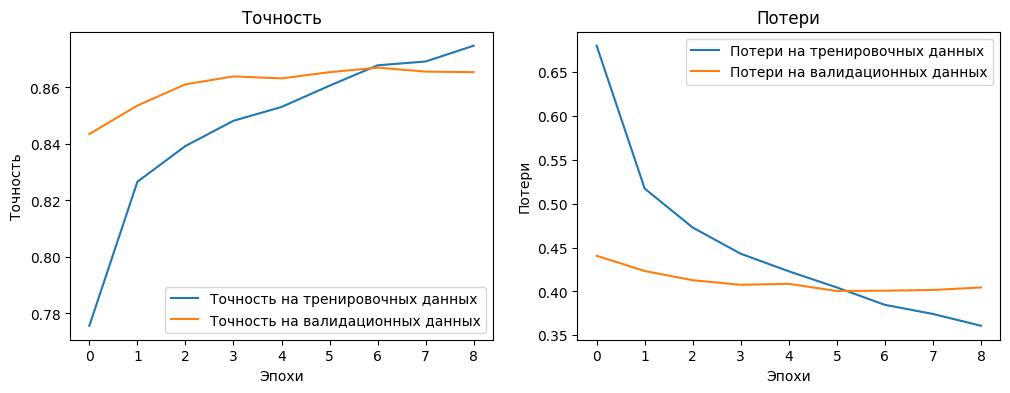

In [ ]:
import matplotlib.pyplot as plt

# Графики обучения (точность и потеря)
plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на тренировочных данных')
plt.plot(history.history['val_accuracy'], label='Точность на валидационных данных')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

# График потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на тренировочных данных')
plt.plot(history.history['val_loss'], label='Потери на валидационных данных')
plt.title('Потери')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step


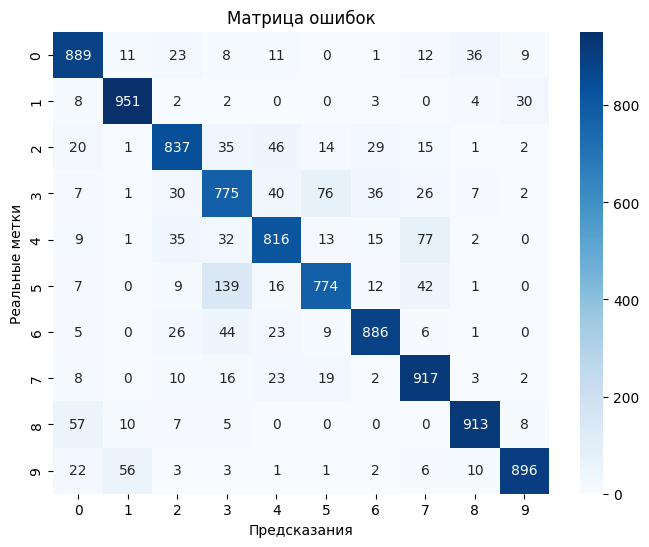

ValueError: multiclass format is not supported

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

# Прогнозирование на тестовых данных
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(NUM_CLASSES), yticklabels=np.arange(NUM_CLASSES))
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Реальные метки')
plt.show()

# ROC-кривые для каждого класса
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])  # для второго класса (изменяй для многоклассовой задачи)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC-кривая (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-кривая')
plt.xlabel('Ложноположительный процент')
plt.ylabel('Истинноположительный процент')
plt.legend(loc='lower right')
plt.show()


1. **Багатокласова класифікація**  
   Це задача, в якій об’єкти належать до одного з більш ніж двох класів (наприклад, 10 категорій у CIFAR-10). На виході мережі є N нейронів (N > 2), кожен відповідає за ймовірність належності до свого класу.  
   **Відмінність від бінарної класифікації**: у бінарній задачі є лише два класи, і зазвичай на виході один нейрон із сигмоїдою (або два з softmax), які відображають ймовірність «так/ні». У багатокласовій — більше вихідних нейронів і softmax на всю множину класів.

2. **Чому softmax у вихідному шарі**  
   - Softmax перетворює необмежені лінійні виходи (логіти) у невід’ємні величини, що в сумі дають 1.  
   - Кожне значення softmax інтерпретується як ймовірність належності зразка до відповідного класу під умовою «саме один клас».  
   - Забезпечує конкурентну взаємодію між нейронами: підвищення одного зменшує інші, що важливо для чіткого вибору одного кращого класу.

3. **Categorical Cross-Entropy і MLE**  
   - Категоріальна крос-ентропія – це від’ємний логарифм правдоподібності цільових міток при моделі softmax.  
   - Максимізація сумарного MLE (Maximum Likelihood Estimation) еквівалентна мінімізації сумарної крос-ентропії між справжнім розподілом (one-hot) і прогнозами моделі.  
   - Тобто, якщо ми вибираємо параметри мережі, що мінімізують categorical cross-entropy, ми максимально правдоподібно описуємо дані нашою моделлю.

4. **Переваги та недоліки CNN для класифікації зображень**  
   **Переваги**  
   - *Автоматичне витягування ознак*: згортки навчаються виявляти краю, текстури, фігури.  
   - *Локальна інваріантність*: за рахунок операцій згортки та пулінгу мережа стійкіша до зсувів і деформацій об’єктів.  
   - *Менша кількість параметрів*: порівняно з повнозв’язними шарами, згортки використовують спільні ваги.  
   **Недоліки**  
   - *Високі обчислювальні витрати* при великій глибині.  
   - *Чутливість до вибору архітектури*: кількість шарів, фільтрів, розмір ядра сильно впливають на результат.  
   - *Потреба в великій кількості даних* для коректного навчання з нуля.

5. **Метрики для багатокласової класифікації**  
   - **Accuracy** (загальна точність) – відсоток правильних передбачень.  
   - **Precision**, **Recall**, **F1-score** для кожного класу (і їх середні значення: macro, weighted).  
   - **Confusion Matrix** – матриця помилок, що дає детальну статистику по кожному класу.  
   - **ROC-AUC** для багатокласового випадку (One-vs-Rest) – площа під ROC-кривою для кожного класу.

6. **Вплив кількості шарів та нейронів**  
   - **Більше шарів/нейронів** підвищує здатність мережі «вивчати» складні залежності (підвищує representational capacity).  
   - Однак занадто велика архітектура – ризик перенавчання і зростання обчислювальних витрат.  \\
   - **Недостатньо шарів/нейронів** – мережа може бути занадто простою й не встигати апроксимувати складні функції, що призводить до недонавчання.

7. **Dropout і його роль**  
   - Dropout випадково «вимикає» певну частину нейронів під час кожної ітерації навчання із заданою ймовірністю (наприклад, p = 0.5).  
   - Це перешкоджає надто тісному «співпрацюванню» вузлів і змушує мережу будувати більш стійкі ознаки.  
   - У результаті зменшується ризик перенавчання, бо кожна підмережа навчається незалежно.

8. **Як визначити перенавчання (overfitting)**  
   - *Висока точність на тренувальному наборі* і *значно нижча на валідаційному/тестовому*.  
   - *Зростання валідаційної втрати* при продовженні навчання, хоча тренувальна втрата продовжує знижуватися.  
   - Графіки loss/accuracy розбігаються: тренувальна криві ростуть/падають однозначно, а валідаційні плавляться.

9. **Раннє зупинення (Early Stopping)**  
   - Механізм відслідковує обрану метрику на валідаційному наборі (наприклад, val_loss).  
   - Якщо протягом заданої кількості епох («patience») метрика не покращується, навчання зупиняється, а модель «відкочується» до найкращих збережених ваг.  
   - Реалізується через колбек `EarlyStopping` у Keras.

10. **Переваги Gradio для інтерфейсу**  
    - **Швидкий старт**: мінімум коду для створення веб-інтерфейсу.  
    - **Інтерактивність**: користувач одразу бачить результати передбачень і може експериментувати з вхідними даними.  
    - **Легке розгортання**: можливо поділитися через публічний URL або інтегрувати в Jupyter/Colab.  
    - **Гнучкість**: підтримує різні типи інпуту/аутпуту (зображення, текст, аудіо, графіки).